# QKeras RNN comparison


## Imports

In [8]:
import tensorflow as tf
import keras
import numpy as np
import time
import random

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Flatten, LSTM, GRU, SimpleRNN, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from collections import deque


from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

import qkeras
from qkeras import *

import hls4ml
import nnlar
from nnlar.datashaper import DataShaper

In [3]:
# Load libraries if they are changed
%load_ext autoreload
%autoreload 2


## Data creation 

In [4]:
from nnlar.datashaper import DataShaper
ds = DataShaper.from_h5("../data/rdgap_mu140.h5")

x, x_val, x_test, y, y_val, y_test = ds()

shapes (1999995, 5, 1) (1999995, 1)
shapes (899992, 5, 1) (99995, 5, 1) (999998, 5, 1)


## Settings

In [5]:
output = 1
integer = (3)

def bit_lenghts(i):
    #To change to create models with different bits parameter by defining the smallest bit lenghts 
    #Example : bits 8 ==> (i+4)*4
    return (i+6)

def bit_width(i): return {'bits': (i+6), 'integer': integer, 'symmetric': 0, 'alpha':1}

bits_range = 3

nbr_epoch = 15

def units(j): return (j+3)*3
units_range = 3

## Classic network

In [6]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=10, 
                                                restore_best_weights=True, 
                                                min_delta=0.000001,
                                                mode='min')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                            patience=5, min_lr=0.000001, verbose=1)

r_model = Sequential()
r_model.add(SimpleRNN(8, input_shape=(5, 1), return_sequences=False, name='SimpleRNN'))
r_model.add(Dense(output, activation='relu',name='dense'))
r_model.compile(loss="mean_squared_error", optimizer=Adam(lr=0.001))


r_model.summary()

#r_model.fit(x,y,validation_data=(x_val,y_val), epochs=1, batch_size=20, shuffle=True, callbacks=[early_stopping, reduce_lr])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 SimpleRNN (SimpleRNN)       (None, 8)                 80        
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


2022-04-28 14:59:05.685816: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-28 14:59:05.686146: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/gcc/9.2.0/x86_64-centos7/bin/:/inteltools/altera/21.1.0.169.pro/gcc/lib64:/inteltools/altera/21.1.0.169.pro/hls/host/linux64/lib
2022-04-28 14:59:05.686206: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/gcc/9.2.0/x86_64-centos7/bin/:/inteltools/altera/21.1.0.169.pro/gcc/lib64:/inteltools/altera/21

## Quantized network

In [34]:
def quantized_model (bits, units, original_weights):  

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    patience=10, 
                                                    restore_best_weights=True, 
                                                    min_delta=0.000001,
                                                    mode='min')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                patience=5, min_lr=0.000001, verbose=1)  
    qr_model = Sequential()
    
    qr_model.add(QSimpleRNN(units,
                        input_dim= 1,
                        activation='relu',   
                        kernel_quantizer=quantized_bits(**bits),
                        bias_quantizer=quantized_bits(**bits)))
       
    #qr_model.add(QActivation(activation=quantized_relu(bits=bits['bits'], integer = bits['integer']), name='relu1'))                   
    qr_model.add(QDense(output, 
                        activation='linear',
                        kernel_quantizer=quantized_bits(**bits),
                        bias_quantizer=quantized_bits(**bits)))
    #qr_model.add(QActivation(activation=quantized_bits(**bits), name='linear1'))
    qr_model.compile(loss="mse", optimizer=Adam(lr=0.0001))
    
    qr_model.summary()
    
    #using the weight from the classic network as a base
    qr_model.set_weights(original_weights.get_weights())
    qr_model.fit(x, y, validation_data= (x_val,y_val),epochs = nbr_epoch, callbacks=[early_stopping, reduce_lr])

    return qr_model

def qmodel_saving (): 
    qmodels =[]
    for i in range(bits_range):
        var_units= []
        for j in range(units_range):
            bits_parameter = bit_width(i)
            units_parameter = units(j)
            var_units.append( quantized_model(bits_parameter,units_parameter, models[j]))
        qmodels.append(var_units)
        print( 'bit width ', bits_parameter)        
    return qmodels
        
qmodels = qmodel_saving()
        

NameError: name 'models' is not defined

## HLS CONVERSION of the keras model, every layer

In [21]:
y_keras = r_model.predict(x_test)
closs=mse(y_test, y_keras)


31250/31250 [==============================] - 17s 550us/step


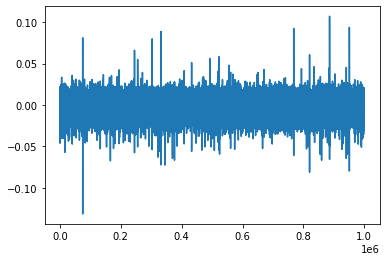

In [32]:
plt.plot(y_keras-y_test)
plt.show()


In [12]:
import hls4ml

hls4ml.__file__

'/atlas/bonnet/hls4ml/hls4ml/hls4ml/hls4ml/__init__.py'

In [14]:

rmodel_json = r_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(rmodel_json)
r_model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [7]:
closs = []
qcloss = []
qchloss = []
ptq_results = []

bit_scale = []
for i in range (bits_range):
    conf = hls4ml.utils.config_from_keras_model( r_model, granularity='name')
    conf['LayerName']['dense']['Precision']['weight'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'
    conf['LayerName']['dense']['Precision']['bias'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'
    conf['LayerName']['SimpleRNN']['Precision'] ={'weight' : f'ap_fixed<{bit_lenghts(i)},{integer+1}>', 'bias': f'ap_fixed<{bit_lenghts(i)},{integer+1}>' }

    
    print(conf)
        
    hls_model = hls4ml.converters.convert_from_keras_model(r_model,
                                                            hls_config=conf,
                                                            output_dir='models/hls_models',
                                                            part='1SG280HU2F50E2VG',
                                                            backend='Quartus')
    hls_model.compile()

    #y_qckeras = tmp_models[i].predict(x_test)
    y_qchls = hls_model.predict(x_test.reshape(x_test.shape[0],1))
    ptq_results.append(y_qchls)
    y_keras = r_model.predict(x_test)
    closs.append(mse(y_test, y_keras))
    #qcloss.append(mse(y_test, y_qckeras))
    qchloss.append(mse(y_test, y_qchls))
    bit_scale.append(bit_lenghts(i))
    plt.figure()
    #plt.plot(y_qckeras, '--', linewidth=2)
    plt.plot(y_qchls)
    plt.plot(y_test)    
    plt.legend(['keras+hls', 'keras'])
    plt.title(f'PTQ : bitwidths of ({bit_lenghts(i)},{integer},0,1)')
    plt.show()

plt.figure()
plt.plot(bit_scale, qchloss)
plt.xlabel('bits')
plt.ylabel('MSE')
plt.title(f'PTQ : bitwidths of (x,{integer},0,1), {nbr_epoch} epochs')

plt.show()

plt.show()

"""
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 
'LayerName': {'simple_rnn_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 
            'simple_rnn': {'Precision': 'ap_fixed<16,6>'}, 
            'simple_rnn_tanh': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 
            'dense': {'Precision': {'weight': 'ap_fixed<16,6>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 
            'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size
 """

Interpreting Sequential
Topology:
Layer name: SimpleRNN_input, layer type: Input
Layer name: SimpleRNN, layer type: SimpleRNN
  -> Activation (tanh), layer name: SimpleRNN
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'SimpleRNN_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'SimpleRNN': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}}, 'SimpleRNN_tanh': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}}}
['Conv1D', 'SeparableConv1D', 'Conv2D', 'SeparableConv2D', 'DepthwiseConv2D', 'InputLayer', 'Dense', 'BinaryDense', 'TernaryDense', 'Activation', 'L

In file included from firmware/parameters.h:11,
                 from firmware/myproject.h:33,
                 from firmware/myproject.cpp:21:
firmware/nnet_utils/simple_rnn_cell.h:2:10: fatal error: HLS/hls.h: No such file or directory
    2 | #include "HLS/hls.h"
      |          ^~~~~~~~~~~
compilation terminated.
In file included from firmware/parameters.h:11,
                 from firmware/myproject.h:33,
                 from myproject_bridge.cpp:4:
firmware/nnet_utils/simple_rnn_cell.h:2:10: fatal error: HLS/hls.h: No such file or directory
    2 | #include "HLS/hls.h"
      |          ^~~~~~~~~~~
compilation terminated.
g++: error: myproject.o: No such file or directory
g++: error: myproject_bridge.o: No such file or directory
g++: fatal error: no input files
compilation terminated.


OSError: models/hls_models/firmware/myproject-EaCAfBFE.so: cannot open shared object file: No such file or directory

## HLS CONVERSION of the QKeras model

## Results